<a href="https://colab.research.google.com/github/SamGrievo/Xg-Model-Machine-Deep-Learning/blob/main/xGmodel_MLP_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install statsbombpy
from statsbombpy import sb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install mplsoccer
from matplotlib.colors import LinearSegmentedColormap
from scipy.ndimage import gaussian_filter
import matplotlib.patheffects as path_effects
from mplsoccer import (VerticalPitch, Pitch, create_transparent_cmap,
                       FontManager, arrowhead_marker, Sbopen)
import math as math
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 152 kB 4.2 MB/s 
     |████████████████████████████████| 47 kB 4.8 MB/s 
     |████████████████████████████████| 127 kB 40.3 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 67 kB 2.7 MB/s 


Pytorch MLP Model

In [69]:
import torch

class MLP(torch.nn.Module):

	def __init__(self,input_size,hidden_size,hidden_size_2):
		super(MLP, self).__init__()

		self.input_size = input_size
		self.hidden_size = hidden_size
		self.hidden_size_2 = hidden_size_2
		self.linear1 = torch.nn.Linear(self.input_size,self.hidden_size)
		self.tanh = torch.nn.Tanh()
		self.linear2 = torch.nn.Linear(self.hidden_size,self.hidden_size_2)
		self.tanh_2 = torch.nn.Tanh()
		self.linear3 = torch.nn.Linear(self.hidden_size_2, 1)
		self.sigmoid = torch.nn.Sigmoid()


	def forward(self, x):
		
		hidden = self.linear1(x)
		act = self.tanh(hidden)
		hidden_ = self.linear2(act)
		act_ = self.tanh_2(hidden_)
		out = self.linear3(act_)
		output = self.sigmoid(out)
		return output



**Functions**


In [3]:
def split_location(dataframe):

  location_x = []
  location_y = []

  for i in range(len(dataframe)):

    location_x.append(dataframe[i][0])
    location_y.append(dataframe[i][1])

  return location_x,location_y

In [4]:
def conversion_rate(total_shots,total_goals):

  conversion_rate = []

  for i in range(len(total_shots.values)):

    conversion = total_goals.values[i]/total_shots.values[i]
    conversion_rate.append(conversion)

  
  df_conversion = pd.DataFrame(index = total_shots.index)
  df_conversion['Converion Rate'] = conversion_rate
  

  return df_conversion

In [5]:
def calculate_distance(dataframe,shot_x,shot_y):

  distance = []
  shortest_dis = 0
  left_post_y = 36
  right_post_y = 44
    

  for i in range(len(dataframe)):
    if shot_x[i] > 60:
      goal_x = 120
      if shot_y[i] < left_post_y:
        distance.append(math.sqrt((abs((shot_x[i] - goal_x)) ** 2) + (abs((shot_y[i] - left_post_y)) ** 2)))
      elif shot_y[i] > right_post_y:
        distance.append(math.sqrt((abs((shot_x[i] - goal_x)) ** 2) + (abs((shot_y[i] - right_post_y)) ** 2)))
      elif left_post_y <= shot_y[i] <= right_post_y:
        distance.append(abs(shot_x[i] - goal_x))
        
    elif shot_x[i] < 60:
      goal_x = 0
      if shot_y[i] < left_post_y:
        distance.append(math.sqrt((abs((shot_x[i] - goal_x)) ** 2) + (abs((shot_y[i] - left_post_y)) ** 2)))
      elif shot_y[i] > right_post_y:
        distance.append(math.sqrt((abs((shot_x[i] - goal_x)) ** 2) + (abs((shot_y[i] - right_post_y)) ** 2)))
      elif left_post_y <= shot_y[i] <= right_post_y:
        distance.append(abs(shot_x[i] - goal_x))

  return distance

In [6]:
def calculate_angle(dataframe,shot_x,shot_y):

  angle = []
  left_post_y = 36
  right_post_y = 44
  a_sqrd_goal_line = 8*8
  error = []

  for i in range(len(dataframe)):

    if 60 < shot_x[i] < 120:
      goal_x = 120
      c_sqrd_left_post = ((shot_x[i] - goal_x)** 2) + ((shot_y[i] - left_post_y) ** 2)
      b_sqrd_right_post = ((shot_x[i] - goal_x) ** 2) + ((shot_y[i] - right_post_y) ** 2)
      angle.append(math.degrees(math.acos(((-a_sqrd_goal_line + b_sqrd_right_post + c_sqrd_left_post)/(2*math.sqrt(b_sqrd_right_post)*math.sqrt(c_sqrd_left_post))  ))))

    elif 0 < shot_x[i] < 60:
      goal_x = 0
      c_sqrd_left_post = ((shot_x[i] - goal_x) ** 2) + ((shot_y[i] - left_post_y) ** 2)
      b_sqrd_right_post = ((shot_x[i] - goal_x) ** 2) + ((shot_y[i] - right_post_y) ** 2)
      angle.append(math.degrees(math.acos(((-a_sqrd_goal_line + b_sqrd_right_post + c_sqrd_left_post)/(2*math.sqrt(b_sqrd_right_post)*math.sqrt(c_sqrd_left_post))  ))))

    elif shot_x[i] >= 120 or shot_x[i] <= 0:
      angle.append(float(0.0))

    


  return angle



Collect statsbomb free data - womens super league 2020/2021

In [7]:
df_events = pd.DataFrame()
df_events = sb.competition_events(country="England",
            division="FA Women's Super League",
            season="2019/2020",
            gender="female", split=True)

Feature engineering (angle, distance, binary shot features)

In [8]:
df_event_shots = pd.DataFrame(df_events['shots'])

In [9]:
df_event_shots.columns

Index(['id', 'index', 'period', 'timestamp', 'minute', 'second', 'type',
       'possession', 'possession_team', 'play_pattern', 'team', 'player',
       'position', 'location', 'duration', 'related_events', 'match_id',
       'shot_statsbomb_xg', 'shot_end_location', 'shot_body_part',
       'shot_technique', 'shot_outcome', 'shot_type', 'shot_freeze_frame',
       'possession_team_id', 'player_id', 'shot_key_pass_id',
       'shot_first_time', 'under_pressure', 'shot_aerial_won',
       'shot_one_on_one', 'shot_saved_to_post', 'shot_deflected',
       'shot_saved_off_target', 'shot_follows_dribble', 'out',
       'shot_open_goal', 'off_camera', 'shot_redirect'],
      dtype='object')

In [10]:
df_event_shots['shot_type'].value_counts()

Open Play    2129
Free Kick      70
Penalty        22
Corner          2
Name: shot_type, dtype: int64

In [11]:

df_event_shots_location = df_event_shots['location']
df_events_shots_reset = df_event_shots_location.reset_index(drop=True)
location_x,location_y = split_location(df_events_shots_reset)

In [12]:
df_event_shots.insert(1,'location_x',location_x)
df_event_shots.insert(1,'location_y',location_y)

In [13]:
shot_distance = calculate_distance(df_event_shots,df_event_shots['location_x'],df_event_shots['location_y'])

In [14]:
df_event_shots.insert(1,'shot_distance',shot_distance)

In [15]:
shot_angles = calculate_angle(df_event_shots,df_event_shots['location_x'],df_event_shots['location_y'])

In [16]:
df_event_shots.insert(1,'shot_angle',shot_angles)

In [17]:
df = {'shot_one_on_one': df_event_shots['shot_one_on_one'].values, 'shot_open_goal': df_event_shots['shot_open_goal'].values, 'shot_first_time': df_event_shots['shot_first_time'].values, 'under_pressure': df_event_shots['under_pressure'].values}
df_binary_features = pd.DataFrame(df)

In [18]:
df_binary_features['shot_first_time'][df_binary_features['shot_first_time'] == True] = 1
df_binary_features['shot_first_time'][df_binary_features['shot_first_time'].isnull()] = -1
df_binary_features['shot_one_on_one'][df_binary_features['shot_one_on_one'] == True] = 1
df_binary_features['shot_one_on_one'][df_binary_features['shot_one_on_one'].isnull()] = -1
df_binary_features['shot_open_goal'][df_binary_features['shot_open_goal'] == True] = 1
df_binary_features['shot_open_goal'][df_binary_features['shot_open_goal'].isnull()] = -1
df_binary_features['under_pressure'][df_binary_features['under_pressure'] == True] = 1
df_binary_features['under_pressure'][df_binary_features['under_pressure'].isnull()] = -1

In [19]:
df_event_shots = df_event_shots.drop(columns=['shot_one_on_one','shot_first_time','shot_open_goal','under_pressure'])

In [20]:
df_event_shots = pd.concat([df_event_shots,df_binary_features], axis=1)

In [21]:
from sklearn.preprocessing import LabelEncoder

lb  = LabelEncoder()
df_event_shots['shot_technique'] = lb.fit_transform(df_event_shots['shot_technique'])

lb_type = LabelEncoder()
df_event_shots['shot_type'] = lb_type.fit_transform(df_event_shots['shot_type'])

Create xg features dataframe

In [22]:
d = {'shot_outcome':df_event_shots['shot_outcome'].values, 'shot_distance': df_event_shots['shot_distance'].values, 'shot_angle': df_event_shots['shot_angle'].values, 'shot_one_on_one': df_event_shots['shot_one_on_one'], 'shot_open_goal': df_event_shots['shot_open_goal'], 'shot_first_time': df_event_shots['shot_first_time'], 'under_pressure': df_event_shots['under_pressure'].values, 'shot_technique':df_event_shots['shot_technique'].values, 'shot_type': df_event_shots['shot_type'].values}
df_xg_features = pd.DataFrame(data=d)

In [23]:
df_xg_features['shot_outcome'][df_xg_features['shot_outcome'] != 'Goal'] = 0
df_xg_features['shot_outcome'][df_xg_features['shot_outcome'] == 'Goal'] = 1
df_xg_features

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,shot_outcome,shot_distance,shot_angle,shot_one_on_one,shot_open_goal,shot_first_time,under_pressure,shot_technique,shot_type
0,0,23.800000,18.831814,-1,-1,-1,-1,4,2
1,0,26.500000,16.929379,-1,-1,-1,-1,4,2
2,0,7.200000,57.930285,-1,-1,1,-1,2,2
3,0,27.300733,16.298755,-1,-1,-1,-1,4,2
4,0,25.100000,17.758730,-1,-1,-1,-1,4,2
...,...,...,...,...,...,...,...,...,...
2218,0,12.900388,21.477965,-1,-1,1,-1,2,2
2219,0,23.547824,13.475304,-1,-1,-1,-1,2,2
2220,0,13.978555,19.797302,-1,-1,-1,-1,4,2
2221,0,24.800000,18.290216,-1,-1,-1,1,4,2


Plot Shots of Goals vs no Goals

In [24]:
plot_goals = df_event_shots[df_event_shots['shot_outcome'] == 'Goal']
plot_no_goals = df_event_shots[df_event_shots['shot_outcome'] != 'Goal']

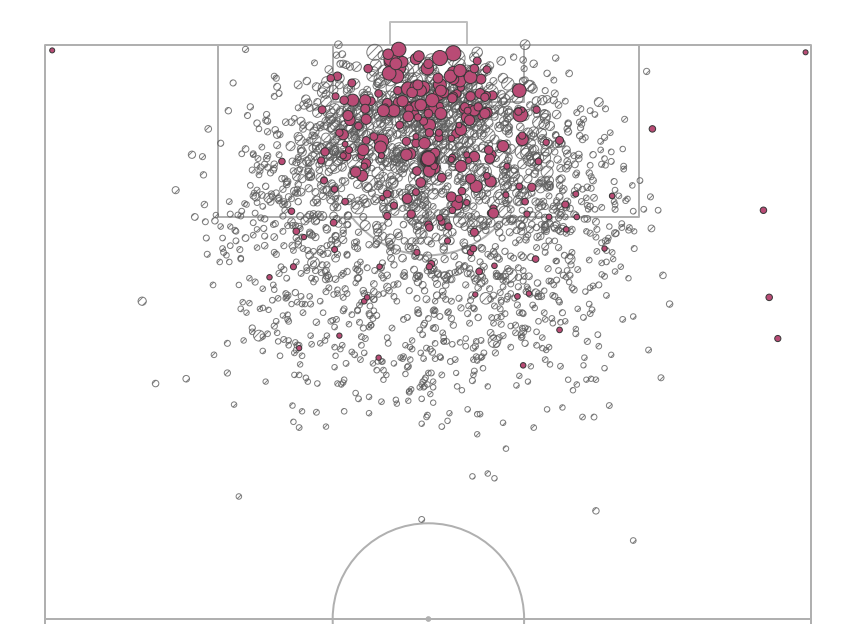

In [25]:
pitch = VerticalPitch(pad_bottom=0.5,  # pitch extends slightly below halfway line
                      half=True,  # half of a pitch
                      goal_type='box',
                      goal_alpha=0.8)  # control the goal transparency
fig, ax = pitch.draw(figsize=(12, 10))


sc2 = pitch.scatter(plot_no_goals['location_x'], plot_no_goals['location_y'],
                    # size varies between 100 and 1900 (points squared)
                    s=(plot_no_goals['shot_statsbomb_xg'] * 1900) + 100,
                    edgecolors='#606060',  # give the markers a charcoal border
                    c='None',  # no facecolor for the markers
                    hatch='///', 
                    marker='.',
                    alpha=0.8,
                    ax=ax)

sc = pitch.scatter(plot_goals['location_x'], plot_goals['location_y'],
                   # size varies between 100 and 1000 (points squared)
                   s=(plot_goals['shot_statsbomb_xg'] * 900) + 100,
                   c='#b94b75',  # color for scatter in hex format
                   edgecolors='#383838',  
                   marker='.',
                   ax=ax)

Prepare data for xG model training

In [26]:
labels = df_xg_features['shot_outcome'].astype(int)
features = df_xg_features.loc[:,df_xg_features.columns!='shot_outcome'].values

In [27]:
scaler = MinMaxScaler((-1,1))
x = scaler.fit_transform(features)
y = np.array(labels)

In [28]:
x_train,x_test,y_train,y_test = train_test_split(x,y, random_state = 42, test_size=0.05)

In [54]:
from torch.autograd import Variable
train_x = Variable((torch.FloatTensor(np.array(x_train))))
train_y = Variable(torch.FloatTensor(np.array(y_train)))
train_dataset = torch.utils.data.TensorDataset(train_x, train_y)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=32 )

test_x = Variable((torch.FloatTensor(np.array(x_test))))
test_y = Variable((torch.FloatTensor(np.array(y_test))))
test_dataset = torch.utils.data.TensorDataset(test_x, test_y)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=16)

# for x,y in trainloader:
#   print(x)

In [70]:
input_size = 8
hidden_size = 50
hidden_size_2 = 50

mlp_pytorch = MLP(input_size,hidden_size, hidden_size_2)
criterion = torch.nn.BCELoss()
optim = torch.optim.Adam(mlp_pytorch.parameters(), lr=0.01)
print(mlp_pytorch)

MLP(
  (linear1): Linear(in_features=8, out_features=50, bias=True)
  (tanh): Tanh()
  (linear2): Linear(in_features=50, out_features=50, bias=True)
  (tanh_2): Tanh()
  (linear3): Linear(in_features=50, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [ ]:
epochs = 50
train_loss = []

for i in range(epochs):
  mlp_pytorch.train()
  for x,y in trainloader:

    optim.zero_grad()
    y_pred = mlp_pytorch(x)
    y_pred = torch.reshape(y_pred, (-1,))
    loss = criterion(y_pred, y)
    loss.backward()
    optim.step()

    train_loss.append(loss.item())

    if i%25 == 1:
        print(f'epoch: {i:3} train loss: {loss.item():10.8f}')

XG for Chelsea Season. 

In [32]:
df_events_ = sb.competition_events(country="England",
            division="FA Women's Super League", 
            season="2020/2021",
            gender="female",split=True)

Create features for the model testing

In [33]:
df_event_shots_ = df_events_['shots']

In [34]:
df_events_location_ = df_event_shots_['location']
df_reset_ = df_events_location_.reset_index(drop=True)

location_x_,location_y_ = split_location(df_reset_)

In [35]:
df_event_shots_.insert(1,'location x',location_x_)
df_event_shots_.insert(1,'location y',location_y_)

In [36]:
shot_distance = calculate_distance(df_event_shots_,df_event_shots_['location x'].values,df_event_shots_['location y'].values)

In [37]:
df_event_shots_.insert(1,'shot_distance',shot_distance)

In [38]:
shot_angles = calculate_angle(df_event_shots_,df_event_shots_['location x'],df_event_shots_['location y'])

In [39]:
df_event_shots_.insert(1,'shot_angle',shot_angles)

In [40]:
df_ = {'shot_one_on_one': df_event_shots_['shot_one_on_one'].values, 'shot_open_goal': df_event_shots_['shot_open_goal'].values, 'shot_first_time': df_event_shots_['shot_first_time'].values, 'under_pressure': df_event_shots_['under_pressure'].values}
df_binary_features_ = pd.DataFrame(df_)

In [41]:
df_binary_features_['shot_first_time'][df_binary_features_['shot_first_time'] == True] = 1
df_binary_features_['shot_first_time'][df_binary_features_['shot_first_time'].isnull()] = -1
df_binary_features_['shot_one_on_one'][df_binary_features_['shot_one_on_one'] == True] = 1
df_binary_features_['shot_one_on_one'][df_binary_features_['shot_one_on_one'].isnull()] = -1
df_binary_features_['shot_open_goal'][df_binary_features_['shot_open_goal'] == True] = 1
df_binary_features_['shot_open_goal'][df_binary_features_['shot_open_goal'].isnull()] = -1
df_binary_features_['under_pressure'][df_binary_features_['under_pressure'] == True] = 1
df_binary_features_['under_pressure'][df_binary_features_['under_pressure'].isnull()] = -1

In [42]:
df_event_shots_ = df_event_shots_.drop(columns=['shot_one_on_one','shot_first_time','shot_open_goal','under_pressure'])

In [43]:
df_event_shots_ = pd.concat([df_event_shots_,df_binary_features_], axis=1)
df_event_shots_

,id,shot_angle,shot_distance,location y,location x,index,period,timestamp,minute,second,...,shot_deflected,shot_saved_off_target,shot_redirect,off_camera,shot_follows_dribble,shot_saved_to_post,shot_one_on_one,shot_open_goal,shot_first_time,under_pressure
0,9076cf40-9179-432a-9663-94cbbff6ce74,15.142123,22.107012,54.6,100.6,92,1,00:01:27.151,1,27,...,NaN,NaN,NaN,NaN,NaN,NaN,-1,-1,-1,-1
1,b3a321bb-597c-49da-b039-21cf7eeb6095,38.829181,10.600000,43.0,109.4,278,1,00:05:21.756,5,21,...,NaN,NaN,NaN,NaN,NaN,NaN,-1,-1,-1,-1
2,87d44b8c-955b-4341-a3c3-c6665fdb37bd,18.583741,24.400000,38.9,95.6,338,1,00:06:57.808,6,57,...,NaN,NaN,NaN,NaN,NaN,NaN,-1,-1,-1,-1
3,ac4a3cfb-cad7-4ebf-8fb1-3e97075fd13e,18.006837,24.407376,44.6,95.6,460,1,00:10:06.492,10,6,...,NaN,NaN,NaN,NaN,NaN,NaN,-1,-1,-1,-1
4,512cd927-1ddf-4921-9d2b-38658736aefe,34.518045,9.289241,33.7,111.0,609,1,00:14:50.232,14,50,...,NaN,NaN,NaN,NaN,NaN,NaN,-1,-1,1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3243,83b225e0-9232-43ba-ba7c-5222eaf7fe81,41.772488,7.414850,34.7,112.7,2548,2,00:26:40.112,71,40,...,NaN,NaN,NaN,NaN,NaN,NaN,-1,-1,1,-1
3244,c46bcd47-083e-426c-9776-bfd662fb4e8b,20.697286,21.500000,37.0,98.5,2795,2,00:35:52.453,80,52,...,NaN,NaN,NaN,NaN,NaN,NaN,-1,-1,1,-1
3245,4604ac2a-2ccf-4f21-a312-51f45d9ef16a,15.546204,29.300000,39.7,90.7,2853,2,00:38:14.196,83,14,...,NaN,NaN,NaN,NaN,NaN,NaN,-1,-1,-1,-1
3246,8c9133e2-5d6e-463b-906a-155482a55b7e,66.132675,5.800000,38.3,114.2,2913,2,00:40:06.591,85,6,...,NaN,NaN,NaN,NaN,NaN,NaN,-1,1,1,-1


In [44]:
lb_  = LabelEncoder()
df_event_shots_['shot_technique'] = lb_.fit_transform(df_event_shots_['shot_technique'])
lb_type_ = LabelEncoder()
df_event_shots_['shot_type'] = lb_type_.fit_transform(df_event_shots_['shot_type'])

Prepare the model testing it with the chelsea game features

In [45]:
df_event_shots_match = df_event_shots_[df_event_shots_['team'] == 'Chelsea FCW'  ]
df_event_shots_match

,id,shot_angle,shot_distance,location y,location x,index,period,timestamp,minute,second,...,shot_deflected,shot_saved_off_target,shot_redirect,off_camera,shot_follows_dribble,shot_saved_to_post,shot_one_on_one,shot_open_goal,shot_first_time,under_pressure
95,af7016ae-3259-477b-a721-f4b76ca90f75,19.214298,22.617913,35.1,97.4,536,1,00:11:32.955,11,32,...,NaN,NaN,NaN,NaN,NaN,NaN,-1,-1,-1,-1
96,cbe01d22-8abf-43b0-8e2d-6e2b1c81f3ed,42.872397,9.800000,42.1,110.2,542,1,00:12:07.273,12,7,...,NaN,NaN,NaN,NaN,NaN,NaN,-1,-1,-1,1
97,235e9ad9-be90-468e-a5fd-d886b2621517,45.915901,8.500000,36.9,111.5,545,1,00:12:07.687,12,7,...,NaN,NaN,True,NaN,NaN,NaN,-1,-1,-1,1
98,abf89d2e-2501-4a36-87f2-3ec4ca9bd78f,21.645779,17.853851,32.0,102.6,573,1,00:13:01.816,13,1,...,NaN,NaN,NaN,NaN,NaN,NaN,-1,-1,1,-1
99,64df1430-0f4f-4492-9581-406fcc373585,21.667369,9.849365,29.5,112.6,656,1,00:16:42.812,16,42,...,NaN,NaN,NaN,NaN,NaN,NaN,-1,-1,1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3215,e5e4d9e9-d610-4a76-aace-a0d47e777239,28.864164,14.900000,36.8,105.1,3103,2,00:34:29.164,79,29,...,NaN,NaN,NaN,NaN,NaN,NaN,-1,-1,1,-1
3216,e64953d1-ee71-4f1c-af4d-86ada6981844,25.210402,11.141364,30.7,110.2,3217,2,00:36:58.215,81,58,...,NaN,NaN,NaN,NaN,NaN,NaN,-1,-1,-1,1
3217,be796e3a-1f75-4e8e-a34d-52f4bd0b7db2,32.839793,13.100000,37.4,106.9,3340,2,00:39:16.432,84,16,...,NaN,NaN,NaN,NaN,NaN,NaN,-1,-1,-1,1
3218,554ae440-b17b-4c73-a86d-d75437214542,17.574088,8.580210,50.9,114.9,3446,2,00:41:27.351,86,27,...,NaN,NaN,NaN,NaN,NaN,NaN,-1,-1,-1,-1


In [46]:
d = {'shot distance': df_event_shots_match['shot_distance'].values, 'shot angle': df_event_shots_match['shot_angle'], 'shot_one_on_one': df_event_shots_match['shot_one_on_one'], 'shot_open_goal': df_event_shots_match['shot_open_goal'], 'shot_first_time': df_event_shots_match['shot_first_time'], 'under_pressure': df_event_shots_match['under_pressure'], 'shot_technique': df_event_shots_match['shot_technique'], 'shot_type': df_event_shots_match['shot_type'].values}
df_test_shots = pd.DataFrame(data=d)

In [47]:
scaler = MinMaxScaler((-1,1))
x_ = scaler.fit_transform(df_test_shots.values)

In [72]:
mlp_pytorch.eval()
x_tensor = torch.Tensor(x_)

xg_mlp_pytorch = mlp_pytorch(x_tensor)
xg_mlp_pytorch.size()
xg_mlp_pytorch = xg_mlp_pytorch.data.numpy()


In [73]:
df_event_shots_match.insert(1,'mlp_xg_pytorch__', xg_mlp_pytorch)

Errors calculated as the difference between the statsbomb xg value and the model xg values

In [74]:
pytorch_xg_error = sum(abs(df_event_shots_match['shot_statsbomb_xg'] - df_event_shots_match['mlp_xg_pytorch__']))/len(df_event_shots_match['shot_statsbomb_xg'])
print('pytorch error:', pytorch_xg_error)

pytorch error: 0.07179676551902216


Xg Boost - exptected goals from chelsea shots for the season

MLP - exptected goals from chelsea shots for the season

MLP Pytorch

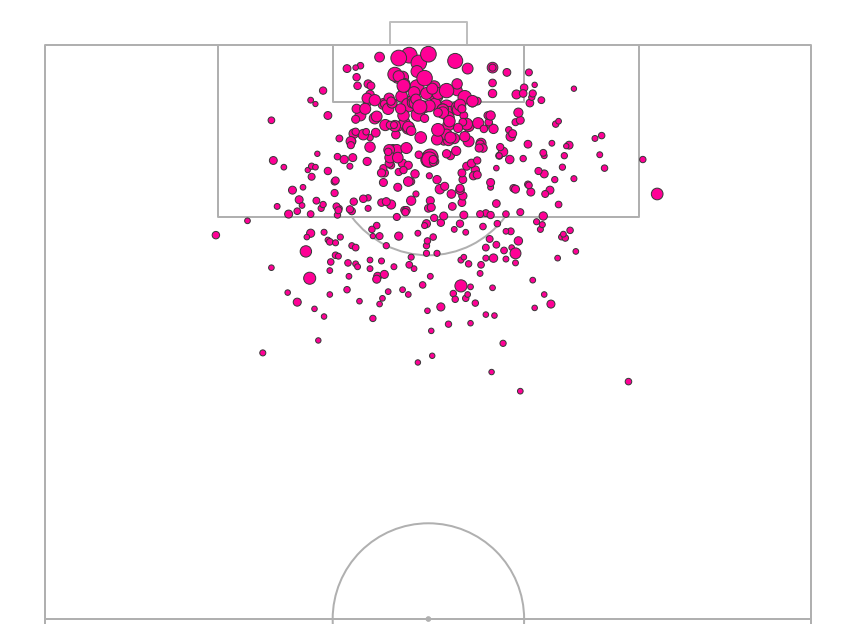

In [75]:
fig, ax = pitch.draw(figsize=(12, 10))


sc = pitch.scatter(df_event_shots_match['location x'], df_event_shots_match['location y'],
                   # size varies between 100 and 1000 (points squared)
                   s=(df_event_shots_match['mlp_xg_pytorch'] * 900) + 100,
                   c='#ff0096',  # color for scatter in hex format
                   edgecolors='#383838',  
                   marker='.',
                   ax=ax)

Statsbomb - exptected goals from chelsea shots for the season

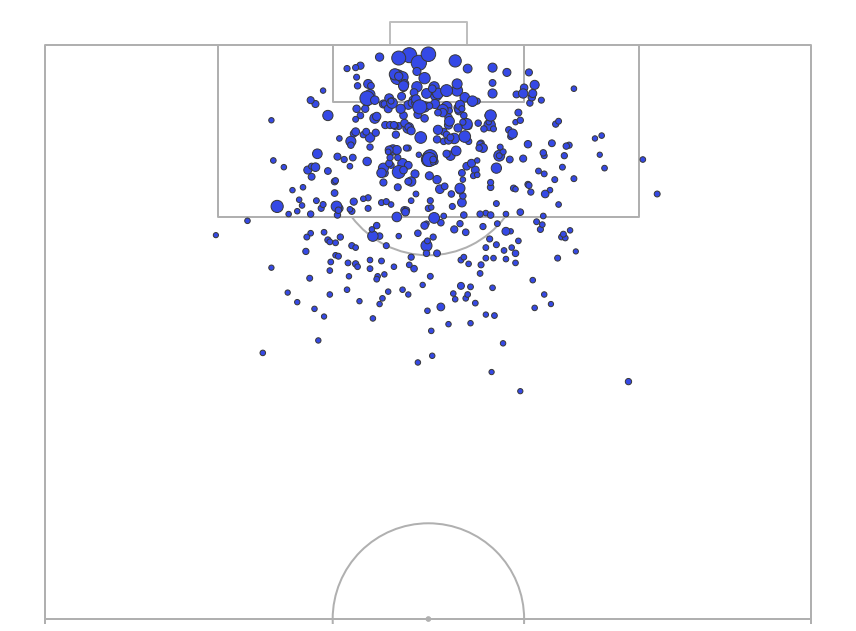

In [65]:
fig, ax = pitch.draw(figsize=(12, 10))
sc1 = pitch.scatter(df_event_shots_match['location x'], df_event_shots_match['location y'],
                   # size varies between 100 and 1000 (points squared)
                   s=(df_event_shots_match['shot_statsbomb_xg'] * 900) + 100,
                   c='#3549e6',  # color for scatter in hex format
                   edgecolors='#383838',  
                   marker='.',
                   ax=ax)